In [1]:

from sklearn.datasets import make_regression
import numpy as np
import pandas as pd
from scipy.stats import expon
import pandas as pd
import numpy as np


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

from sklearn import set_config
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder

from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import brier_score

from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

from sklearn.model_selection import KFold
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from scipy.stats import logrank, ecdf
from sksurv.nonparametric import ipc_weights 
import warnings
warnings.filterwarnings('ignore')


np.random.seed(42)

In [2]:
from sklearn.datasets import make_regression

import numpy as np
n_samples = 1000
hazard_ratio = 2.0
random_state = 42
X, y = make_regression(n_samples=n_samples, n_features=10, noise=1, random_state=n_samples)
time_event =  abs(y)
event = np.full(n_samples, True)
max_time = max(y)
from sksurv.util import Surv
yt = Surv.from_arrays(event=event, time=time_event)
df_uncen = pd.DataFrame(X).join(pd.DataFrame(yt))

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, yt, test_size=0.2, random_state=random_state)

# Create censored data


In [4]:

def censor_data(data):
# Generate a random censoring amount between 0.1 and 0.3
    random_censoring = np.random.uniform(0.1, 0.3)

# Determine the number of observations to censor
    n_to_censor = int(len(data) * random_censoring)

# Ensure we do not exceed the length of the DataFrame
    n_to_censor = min(n_to_censor, len(data))

# Randomly select indices to censor
    counter_list = np.random.choice(len(data), n_to_censor, replace=False)

    data_cen = pd.DataFrame(columns=['event','time'])
    counter = 0
    for event, time in data:
    
        if counter in counter_list:
            event = False
            time_cen = np.random.uniform(low=0, high=time, size=1)
            time = time_cen
       

    
        
        data_cen.loc[counter] =  [event,time]
        counter += 1
    return data_cen


In [5]:
y_cen = censor_data(yt)
yt_cen = Surv.from_arrays(event=y_cen['event'], time=y_cen['time'])

## create dataframe
#CCA

In [6]:
cca_df= pd.DataFrame(X).join(pd.DataFrame(yt_cen))
cca_data = cca_df[cca_df['event']==True]
cca_yt = Surv.from_arrays(event=cca_data['event'], time=cca_data['time'])
cca_X = cca_data[cca_data.columns[:-2]]

## Plot the difference in time of the dataset

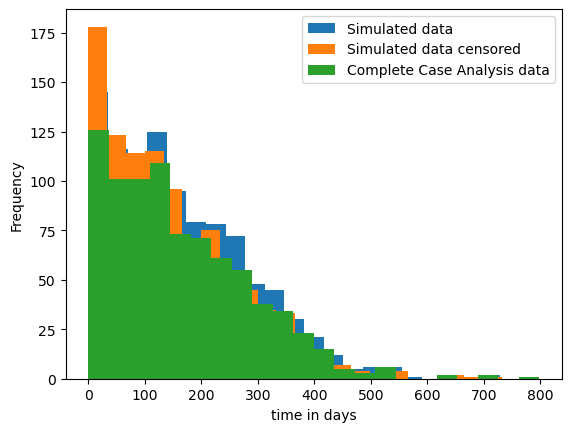

In [7]:
plt.hist(yt['time'], bins='auto', label= 'Simulated data')  # arguments are passed to np.histogram
plt.hist(yt_cen['time'], bins='auto', label= 'Simulated data censored')  # arguments are passed to np.histogram
plt.hist(cca_yt['time'], bins='auto', label= 'Complete Case Analysis data')  # arguments are passed to np.histogram
plt.xlabel('time in days')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#Convert to DF
combine X and time event for better control;

In [8]:
df= pd.DataFrame(X).join(pd.DataFrame(yt_cen))


# Metric functions

## Create function to test all metrics in one swoop

def test_metrics(models, X_train, y_train, X_test, y_test, df):
    from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score, brier_score
)
    #print(len(models))

    metrics_dic = {}
    # Max time calculation for evaluation
     # Get the range of observed times in y_test
    min_time = y_test['time'].min()+ 1
    max_time = y_test['time'].max() -1
    #print("Min time:", y_test['time'].min())
    #print("Max time:", y_test['time'].max())

    # Generate the time points for AUC computation, constrained to the range of y_test['time']
    times = np.linspace(min_time, max_time, num=20)
    
    # Clip times to ensure they are within the range of observed times in y_test
    times = np.clip(times, min_time, max_time)
    for model in models:
        scores = {}
    #c-index
        c_index = model.score(X_test, y_test)
        scores['C-index'] = round(c_index,3)


   
    # Brier score
        survs = model.predict_survival_function(X_test)

    
        preds = [fn(max_time) for fn in survs]
        score_brier = brier_score(y_train, y_test, preds, max_time)
        scores['Brier score'] = round(float(score_brier[1]),4)


        metrics_dic[f'{str(model)}'] = scores


    return metrics_dic

def time_dependent_roc(models, model_name, X_train, y_train, X_test, y_test, df):
    # Get the range of observed times in y_test
    min_time = y_test['time'].min()+ 1
    max_time = y_test['time'].max() -1
    #print("Min time:", y_test['time'].min())
    #print("Max time:", y_test['time'].max())

    # Generate the time points for AUC computation, constrained to the range of y_test['time']
    times = np.linspace(min_time, max_time, num=20)
    
    # Clip times to ensure they are within the range of observed times in y_test
    times = np.clip(times, min_time, max_time)
    
    model_auc_dic = {}
    
    for model in models:
        temp_dic = {}
        
        # Ensure the model has a cumulative hazard function
        temp_dic[f'{model_name}_funcs'] = model.predict_cumulative_hazard_function(X_test, return_array=False)
        
        # Compute scores based on the cumulative hazard function at each time point
        temp_dic[f'{model_name}_scores'] = np.vstack([chf(times) for chf in temp_dic[f'{model_name}_funcs']])
        
        # Compute time-dependent AUC (assuming 'cumulative_dynamic_auc' is defined elsewhere)
        temp_dic[f'{model_name}_auc'], temp_dic[f'{model_name}_mean_auc'] = cumulative_dynamic_auc(y_train, y_test, temp_dic[f'{model_name}_scores'], max_time)
        
        # Store model AUC values
        model_auc_dic[model_name] = temp_dic
        
        # Plot AUC curve for the current model
        plt.plot(times, temp_dic[f'{model_name}_auc'], "o-", label=f"{model_name} (mean AUC = {temp_dic[f'{model_name}_mean_auc']:.2f})")
    
    plt.xlabel("Days after Enrollment")
    plt.ylabel("time-dependent AUC")
    plt.legend(loc="lower center")
    plt.grid(True)
    plt.show()

In [9]:
def time_dependent_roc(model, y_train, X_test, y_test, model_name):
    temp_y_train = np.asanyarray(y_train['time'])
    temp_y_test = np.asanyarray(y_test['time'])
    y = np.concatenate([temp_y_train, temp_y_test])
    lower, upper = np.percentile(y, [10, 90])
    times = np.arange(lower, upper + 1)
    
    estimates = model.predict_cumulative_hazard_function(X_test, return_array=False)
    estimates_values = np.array([fn(times) for fn in estimates])
    auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, estimates_values, times)
    if np.isnan(mean_auc) or np.isnan(auc).any():
        mean_auc = np.nanmean(auc) 
    plt.plot(times, auc, label=f"{model_name} (Mean AUC: {mean_auc:.3f})")
    plt.axhline(mean_auc, linestyle="--")
    plt.xlabel("Time")
    plt.ylabel("AUC")
    #plt.title("Time-Dependent ROC Curve")
    plt.legend(loc="best")
    plt.grid(True)
    
    

In [10]:
def c_index(model, y_train, X_test, y_test):
    c_index = model.score(X_test, y_test)
    return c_index

In [11]:
# Brier score
def brier_score_cal(model, y_train, X_test, y_test):
    temp_y_train = np.asanyarray(y_train['time'])
    temp_y_test = np.asanyarray(y_test['time'])
    y_time = np.concatenate([temp_y_train, temp_y_test])
    lower, upper = np.percentile(y_time, [10, 90])
    print(lower,upper)
    times = np.arange(lower, upper+1)
    survs = model.predict_survival_function(X_test)

    #train_times = y_train["time"]
    #test_times = y_test["time"]

# Define time points and ensure they are within test data range
    #times = np.linspace(train_times.min(), train_times.max(), 50)
    #valid_times = times[(times >= test_times.min()) & (times <= test_times.max())]


    preds  = np.asarray([[fn(t) for t in times] for fn in survs])



    #preds = [fn(max_time) for fn in survs]
    try:
        score_brier = integrated_brier_score(y_train, y_test, preds, times)
    except:
        #temp_y_train = np.asanyarray(y_train['time'])
        #temp_y_test = np.asanyarray(y_test['time'])
        #y = np.concatenate([temp_y_train, temp_y_test])
        lower, upper = np.percentile(preds, [10, 90])
        times = np.arange(lower, upper + 1)
        score_brier = integrated_brier_score(y_train, y_test, preds, times)
    #Brier_score = round(float(score_brier[1]),4)
    return score_brier



In [12]:
import numpy as np

# Helper function to calculate the time interval for prediction
def IB_time_interval(y_train, y_test):
    # Get the times from the train and test datasets
    y_times_tr = [i['time'] for i in y_train]
    y_times_te = [i['time'] for i in y_test]

    # Calculate the 5th and 95th percentiles for both train and test times
    T1 = np.percentile(y_times_tr, 5, interpolation='higher')
    T2 = np.percentile(y_times_tr, 95, interpolation='lower')
    T3 = np.percentile(y_times_te, 5, interpolation='higher')
    T4 = np.percentile(y_times_te, 95, interpolation='lower')

    # Generate time points within the valid range
    time_range = np.linspace(np.maximum(T1, T3), np.minimum(T2, T4), num=100)

    # Ensure the time range does not exceed the maximum time in the test data
    max_test_time = np.max(y_times_te)  # Get the maximum observed time in test data
    time_range = time_range[time_range <= max_test_time]  # Clip time range to the maximum test time

    return time_range


# Function to calculate Brier score
def brier_score_cal2(model, y_train, X_val, y_val):
    # Get the time points for prediction
    times = IB_time_interval(y_train, y_val)  # time points for which survival functions are estimated

    # Ensure the prediction times don't exceed the maximum time observed in the validation set
    max_test_time = np.max([i['time'] for i in y_val])  # Maximum observed time in validation set
    times_clipped = np.clip(times, a_min=None, a_max=max_test_time)  # Clip the time points

    # Debug: Check the range of clipped times
    #print(f"Clipped times range: {times_clipped.min()} to {times_clipped.max()}")

    # Generate predictions at the clipped times
    survs = model.predict_survival_function(X_val)  # Assuming this is a list of callable functions

    # Ensure that predictions are calculated at the clipped times
    predictions = np.asarray([[fn(t) for t in times_clipped] for fn in survs])

    # Debug: Ensure predictions are calculated correctly
    #print(f"Predictions shape: {predictions.shape}")
   # print(f"Times used for predictions: {times_clipped[:5]}")  # Display a few time points

    # Verify that the predictions correspond to the correct clipped times
    assert np.all(times_clipped >= np.min(times)), f"Error: some times are below minimum observed time"
    assert np.all(times_clipped <= np.max(times)), f"Error: some times exceed maximum observed time"
    
    # Check if y_train and y_val are in the correct structured array format
    #print(f"y_train structured format: {y_train.dtype}, y_val structured format: {y_val.dtype}")

    # Calculate the Brier score using the clipped times and predictions
    try:
        score_brier = integrated_brier_score(y_train, y_val, predictions, times_clipped)  # You need to make sure this function is defined
        #print(f"Brier score: {score_brier}")
    except ValueError as e:
        #print(f"Brier score calculation error: {e}")
        score_brier = None  # Return None in case of an error

    return score_brier


In [13]:
def metrics(zip_model):
    model, y_train, X_test, y_test, model_name = zip_model
    brier = brier_score_cal2(model, y_train, X_test, y_test)
    concordance_index = c_index(model, y_train, X_test, y_test)
    plot= time_dependent_roc(model, y_train, X_test, y_test, model_name)
    
    return brier, concordance_index, plot

In [14]:
def hyper_tuning(X_train, y_train, model, weights = None):
    # Outer CV
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=random_state)

    # Store results
    outer_results = []
    best_params = []
    ibs_scores = []

    for train_idx, val_idx in outer_cv.split(X_train):
        # Split into training and validation sets
        X_outer_train, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_outer_train, y_val = yt[train_idx], yt[val_idx]

        # Define parameter grid
        param_grid = {
            "max_features": ["sqrt", "log2"],
            #"max_depth": [3, 5, None],
            "min_samples_split": [2, 5, 10],
        }

        # Define scoring function for GridSearchCV
        def score_survival_model(estimator, X, y):
            prediction = estimator.predict(X)  # Should return survival functions
            result = concordance_index_censored(y["event"], y["time"], prediction)
            return result[0]

        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            scoring=score_survival_model,
            cv=3,  # Inner CV
            n_jobs=-1,
        )

        # Fit the model
        grid_search.fit(X_outer_train, y_outer_train)

        # Get the best model and parameters
        best_rsf = grid_search.best_estimator_
        best_params.append(grid_search.best_params_)

        # Compute integrated Brier score for the best model
        try:
            ibs = brier_score_cal2(best_rsf, y_outer_train, X_val, y_val)
            ibs_scores.append(ibs)
        except Exception as e:
            #print(f"Error computing Brier score: {e}")
            ibs_scores.append(None)

    # Filter out None values in ibs_scores
    ibs_scores = [score for score in ibs_scores if score is not None]

    if len(ibs_scores) == 0:
        #print("Error: No valid Brier scores computed")
        return None, None, None, None

    # Select the best model from outer CV
    best_index = np.argmin(ibs_scores)
    final_best_params = best_params[best_index]

    #print(f"Best hyperparameters: {final_best_params}")

    # Train the final model on the full training set
    final_model = RandomSurvivalForest(**final_best_params, random_state=random_state)
    final_model.fit(X_train, y_train, sample_weight=weights)

    return final_model

# Basline model

In [15]:
def basic_rsf(df, random_state=42):
    model_name = 'Baseline RSF'
    rsf = RandomSurvivalForest(random_state=random_state, n_estimators=50)

    # Convert data to survival format
    yt = Surv.from_arrays(event=df["event"], time=df["time"])
    X = df.drop(columns=["event", "time"])

    # Split data for outer loop
    X_train, X_test, y_train, y_test = train_test_split(
        X, yt, test_size=0.2, random_state=random_state
    )
    
    final_model = hyper_tuning(X_train, y_train, rsf)

    zipped_info = [final_model, y_train, X_test, y_test, model_name]
    return zipped_info


(0.08789089680770762, 0.7249532460593107, None)


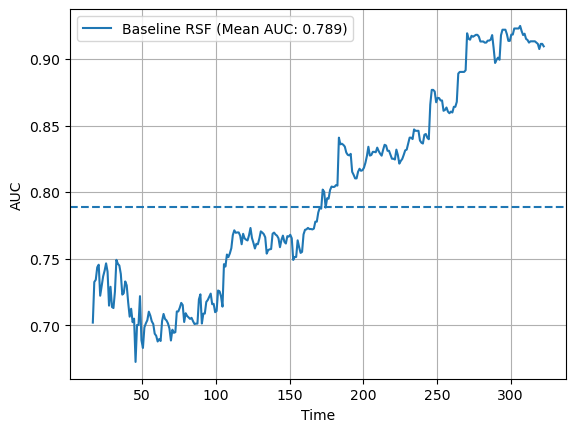

In [16]:
print(metrics(basic_rsf(df)))

## Creating models using the different methods

In [17]:
## CCA
def complete_case_analysis(df):
    model_name = 'CCA'
    rsf = RandomSurvivalForest(random_state = random_state, n_estimators=1000)
    
    cca_df= pd.DataFrame(X).join(pd.DataFrame(yt_cen))
    cca_data = cca_df[cca_df['event']==True]
    cca_yt = Surv.from_arrays(event=cca_data['event'], time=cca_data['time'])
    cca_X = cca_data.drop(columns=['event', 'time'])

    X_train, X_test, y_train, y_test = train_test_split(cca_X, cca_yt,stratify=cca_yt['event'], test_size=0.2, random_state=random_state)

    rsf_cca = hyper_tuning(X_train, y_train, rsf)
    

   #results = test_metrics([rsf_cca], X_train,  y_train, X_test, y_test)
    #plot = time_dependent_roc([rsf_cca],'CCA', X_train,  y_train, X_test, y_test, cca_df)
    zipped_info = [rsf_cca, y_train, X_test, y_test, model_name]
    return zipped_info

## Imputation

In [18]:
import numpy as np
import pandas as pd
from lifelines import WeibullFitter
from scipy.stats import weibull_min

def imputation_model(df):
    model_name = 'Imputation'
    def impute_surv_data(df):
        
        censored_data = df[df['event'] == 0].copy()
        uncensored_data = df[df['event'] == 1].copy()

    # 1. Fit a Weibull model to uncensored data

        uncensored_data['time'] = uncensored_data['time'].replace(0.0, 0.0001)
        censored_data['time'] = censored_data['time'].replace(0.0, 0.0001)
        weibull_fitter = WeibullFitter()
        weibull_fitter.fit(uncensored_data['time'], event_observed=uncensored_data['event'])

    # Get Weibull parameters for sampling
        weibull_shape = weibull_fitter.rho_
        weibull_scale = weibull_fitter.lambda_

    # 2. Impute times for censored data using the Weibull distribution
        imputed_times = []
        for index, row in censored_data.iterrows():
            observed_time = row['time']
            
            # Generate a potential event time from the Weibull distribution
            potential_event_time = weibull_min.rvs(c=weibull_shape, scale=weibull_scale)
            
            # Ensure the imputed event time is after the observed (censored) time
            if potential_event_time > observed_time:
                imputed_times.append(potential_event_time)
            else:
                imputed_times.append(observed_time + weibull_min.rvs(c=weibull_shape, scale=weibull_scale))  # Add additional time if needed

        # Add imputed times to the censored data
        censored_data['imputed_time'] = imputed_times

        # For uncensored data, the imputed time is the observed time
        uncensored_data['imputed_time'] = uncensored_data['time']

        # Combine censored and uncensored data back together and set all events to 1
        df_imputed = pd.concat([uncensored_data, censored_data], axis=0).sort_index()
        df_imputed['event'] = 1  # Set all events to 1

        return df_imputed[df_imputed.columns[:-3]], df_imputed[['event','imputed_time']]
    rsf = RandomSurvivalForest(random_state = random_state, n_estimators=1000)
    X, y = impute_surv_data(df)
    
    yt = Surv.from_arrays(event=y['event'].astype('bool'), time=y['imputed_time'].rename('time'))
    
    #train test split
    X_train, X_test, y_train, y_test = train_test_split(X, yt,stratify=yt['event'], test_size=0.2, random_state=random_state)


    #k-fold 
    #kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42
    #score = cross_val_score(ensemble.RandomForestRegressor(random_state= 42), X, y, cv= kf, scoring="neg_mean_squared_error")
#print(f'Scores for each fold are: {score}')
#rmse(score.mean())
    rsf_imp = hyper_tuning(X_train, y_train, rsf)
    

    #results = test_metrics([rsf_imp], X_train,  y_train, X_test, y_test)
    #plot = time_dependent_roc([rsf_imp],'Imputation', X_train,  y_train, X_test, y_test, cca_df)

    zipped_info = [rsf_imp, y_train, X_test, y_test, model_name]
    return zipped_info


# STUART

In [19]:
import numpy as np
import pandas as pd
from sksurv.ensemble import RandomSurvivalForest
from scipy.stats import norm

def stuart(df):
    #STUART method
    model_name = 'STUART'
    # Function to train a base model
    def train_base_model(observed):
        # Prepare features (X) and survival data (y) for Random Survival Forest
        X_train = observed.drop(columns=['time', 'event'])
        y_train = observed[['event', 'time']].to_records(index=False)
        
        # Initialize and train the Random Survival Forest
        model = RandomSurvivalForest(n_estimators=100, min_samples_split=10, min_samples_leaf=3, random_state=0)
        model.fit(X_train, y_train)
        
        return model


    def predict_survival_time(model, censored):
        X_censored = censored.drop(columns=['time', 'event'])
        
        # Predict survival functions for each instance
        survival_functions = model.predict_survival_function(X_censored)
        
        predictions = []
        variances = []
        
        # Iterate over survival functions and compute the median survival time (Tp)
        for surv_func in survival_functions:
            # surv_func is a StepFunction object
            # surv_func.x contains the time points and surv_func.y contains the survival probabilities
            
            # Find the time point where survival probability is closest to 50%
            median_time = surv_func.x[np.argmin(np.abs(surv_func.y - 0.5))]  # Median survival time
            
            predictions.append(median_time)
            
            # Variance estimation (currently a placeholder, can be refined)
            variances.append(2.0)  # Placeholder variance for simplicity
        
        return np.array(predictions), np.array(variances)


    # Function to calculate tolerance interval
    def calculate_tolerance_interval(predictions, variances, confidence_level=0.95):
        # Calculate 95% tolerance interval using normal distribution
        z_score = norm.ppf(1 - (1 - confidence_level) / 2)
        lower_bound = predictions - z_score * np.sqrt(variances)
        upper_bound = predictions + z_score * np.sqrt(variances)
        return lower_bound, upper_bound

    # Function to update the training set with confident predictions
    def update_training_set(censored, observed, predictions, variances, lower_bound, upper_bound):
        confident_predictions = []
        new_observed = observed.copy()

        for idx, (prediction, variance, lb, ub) in enumerate(zip(predictions, variances, lower_bound, upper_bound)):
            Tc = censored.iloc[idx]['time']  # Censoring time of the instance
            
            # Check if Tc > Tp + 2σ to consider it confident
            if Tc > prediction + 2 * np.sqrt(variance):
                # Add confident prediction to training data (observed) and remove from censored
                new_observed = pd.concat([new_observed, censored.iloc[[idx]]], ignore_index=True)
                confident_predictions.append(True)
            else:
                confident_predictions.append(False)
        
        # Update censored to remove confident predictions
        new_censored = censored[~np.array(confident_predictions)]
        
        return new_observed, new_censored

    # Main function to run the iterative process with Random Survival Forest
    def survival_prediction_model(observed, censored, max_iterations=50):
        iteration = 0
        while iteration < max_iterations:
            iteration += 1
            
            # Train the base Random Survival Forest model on observed data
            model = train_base_model(observed)
            
            # Make predictions for censored instances
            predictions, variances = predict_survival_time(model, censored)
            
            # Sort predictions based on minimum variance (if required)
            sorted_indices = np.argsort(variances)
            predictions = predictions[sorted_indices]
            variances = variances[sorted_indices]
            censored_sorted = censored.iloc[sorted_indices]
            
            # Calculate the tolerance interval for predictions
            lower_bound, upper_bound = calculate_tolerance_interval(predictions, variances)
            
            # Identify confident predictions to add to the training set
            observed, censored = update_training_set(censored_sorted, observed, predictions, variances, lower_bound, upper_bound)
            
            # Stop if no new confident predictions are added
            if observed.shape[0] == len(observed):  # Check if training set size increased
                #print(f"Iteration {iteration}: No confident predictions added.")
                break

        return model, observed
    observed  = df[df['event']==True]
    censored = df[df['event']==False]
    observed['event'] = observed['event'].astype(bool)
    censored['event'] = censored['event'].astype(bool)
    final_model, final_observed = survival_prediction_model(observed, censored)

    def prepare_data(data):
        event_time = Surv.from_arrays(event=data['event'], time=data['time'])
        features = data[data.columns[:-2]]

        return  features, event_time
    stuart_X , stuart_y = prepare_data(final_observed)

    X_train, X_test, y_train, y_test = train_test_split(stuart_X, stuart_y, stratify=stuart_y['event'], test_size=0.2, random_state=random_state)
    rsf = RandomSurvivalForest(random_state = random_state, n_estimators=1000)
    rsf_stuart = hyper_tuning(X_train, y_train, rsf)
        

    #results = test_metrics([rsf_stuart], X_train,  y_train, X_test, y_test, cca_df)
    #plot = time_dependent_roc([rsf_stuart],  'STUART', X_train,  y_train, X_test, y_test, cca_df)
    #return results, plot

    zipped_info = [rsf_stuart, y_train, X_test, y_test, model_name]
    return zipped_info

In [20]:
## ICPW

def icpw_model(df):
    model_name = 'ICPW'
    rsf = RandomSurvivalForest(random_state = random_state, n_estimators=1000)
    #from sklearn.linear_model import LogisticRegression


    
    event_time = Surv.from_arrays(event=df['event'].astype(bool), time=df['time'])
    features = df[df.columns[:-2]]

    
    
    
# Fit a logistic regression model to predict censoring
    #X_censor =  features

    #y_censor = 1  - event_time['event'].astype('int')  # 1 for censored, 0 for event
    # Assuming `survival_data` is your original dataset
 
    
# Check dimensions again before fitting
    

#cca_yt = Surv.from_arrays(event=cca_data['event'], time=cca_data['time'])
    #model = LogisticRegression()
    #model.fit(X_censor, y_censor)

    yt = pd.DataFrame(columns=['event', 'time'], data= event_time)
# Predict the probability of being censored
    #censor_prob = model.predict_proba(X_censor)[:, 1]
    #yt['weights'] = 1 / censor_prob
    yt['weights'] = ipc_weights(event_time['event'], event_time['time'])


    X_train, X_test, y_train, y_test = train_test_split(features, yt, stratify=yt['event'], test_size=0.2, random_state=random_state)
    yt_temp_train = Surv.from_arrays(event=y_train['event'].astype(bool), time=y_train['time'])
    yt_temp_test = Surv.from_arrays(event=y_test['event'].astype(bool), time=y_test['time'])
    
    #rsf_ICPW = rsf.fit(X_train,yt_temp_train , np.asanyarray(y_train['weights'].values))
    rsf_ICPW = hyper_tuning(X_train, yt_temp_train, rsf, weights=np.asanyarray(y_train['weights'].values))
    #results = test_metrics([rsf_ICPW], X_train,  yt_temp_train, X_test, yt_temp_test)
   # plot = time_dependent_roc(rsf_ICPW,'ICPW', X_train,  yt_temp_train, X_test, yt_temp_test, cca_df)

    #return results, plot
    zipped_info = [rsf_ICPW, yt_temp_train, X_test, yt_temp_test, model_name]
    return zipped_info


# train basic on uncesored data
- get all metrics

# Plot all roc in one plot

In [21]:
models = [basic_rsf, complete_case_analysis, imputation_model,icpw_model, stuart ]

In [ ]:

for model in models:
    print(metrics(model(df)))
plt.xlabel("Days after Enrollment")
plt.ylabel("time-dependent AUC")
plt.legend(loc="lower center")
plt.grid(True)
plt.show()



(0.08789089680770762, 0.7249532460593107, None)
(0.1437120427695631, 0.7025921869295363, None)
(0.14778879061263459, 0.679748743718593, None)
(0.14839120492447153, 0.6734585518019512, None)


# real world data

In [ ]:
survival_data = pd.read_csv('/Users/robinlaheij/Downloads/hcc-survival/hcc-data.txt', header = None)
# Rename the last two columns
survival_data = survival_data.rename(columns={survival_data.columns[-2]: 'time', survival_data.columns[-1]: 'event'})

# prepare data 
survival_data = survival_data.replace('?', np.nan)
# Select all columns except the last two

survival_data[survival_data.columns[:-2]] = survival_data[survival_data.columns[:-2]].astype(float)
# Impute missing values with the mean for the selected columns
cols_to_impute = survival_data.columns[:-2]
survival_data[cols_to_impute] = survival_data[cols_to_impute].fillna(survival_data[cols_to_impute].mean())

# if time is missing 

# Set 'event' to 0 where 'time' is missing as we dont know when the event was
survival_data.loc[survival_data['time'].isna(), 'event'] = 0
survival_data['time'] = survival_data['time'].astype(float)
survival_data.loc[survival_data['time'] == 0.0, 'time'] = 0.001
survival_data['time'] = survival_data['time'].fillna(survival_data['time'].median()).astype(float)

y_surv= Surv.from_arrays(event=survival_data['event'], time=survival_data['time'])
X_surv = survival_data.drop(columns=['event', 'time'])


In [ ]:
X_train_surv, X_test_surv, y_train_surv, y_test_surv = train_test_split(X_surv, y_surv,stratify=y_surv['event'], test_size=0.2, random_state=random_state)
# train
df_train_surv = pd.DataFrame(X_train_surv).join(pd.DataFrame(y_train_surv))

# test
df_test_surv = pd.DataFrame(X_test_surv).join(pd.DataFrame(y_test_surv))

In [ ]:
models = [basic_rsf, complete_case_analysis, imputation_model,icpw_model, stuart ]

<function basic_rsf at 0x17fa94c20>
(0.2110989258208193, 0.7877358490566038, None)
<function complete_case_analysis at 0x17fbdc0e0>
(0.1430045423883991, 0.7147466057265761, None)
<function imputation_model at 0x17fbb3e20>
(0.18175481430865378, 0.5700757575757576, None)
<function icpw_model at 0x17fbf04a0>
(0.3886770908383791, 0.41379310344827586, None)
<function stuart at 0x17fc47d80>
(0.18370469670016712, 0.765625, None)


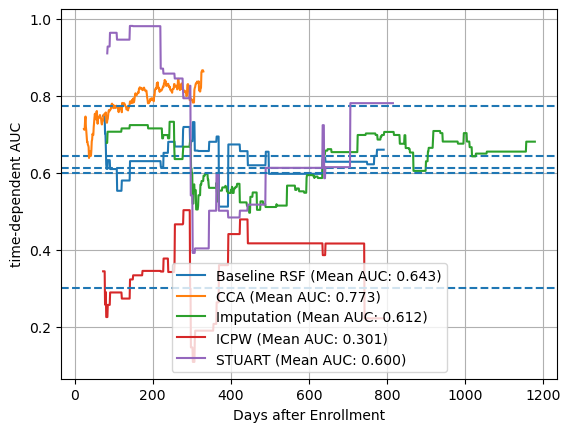

In [ ]:
for model in models:
    print(model)
    print(metrics(model(survival_data)))
plt.xlabel("Days after Enrollment")
plt.ylabel("time-dependent AUC")
plt.legend(loc="lower center")
plt.grid(True)
plt.show()
